In [34]:
%%file esn_classifier.py
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import scipy.sparse as sparse

class EsnClassifier(BaseEstimator, ClassifierMixin):
    """Echo state network classifier"""
    def __init__(self, \
                 density=1, reservoirSize=100, outputleakingRate=1, \
                 inputSize=1, outputSize=1, leakingRate = 1, \
                 randomState=None, regularizationCoefficient=10e-6,
                 alpha=None):
        """
        Called when initializing the classifier
        """
        self.density = density
        self.reservoirSize = reservoirSize
        self.leakingRate = leakingRate
        self.randomState = randomState
        self.outputSize = outputSize
        self.inputSize = inputSize
        self.alpha = alpha
        self.regularizationCoefficient = regularizationCoefficient
    
    def fit(self, X, y=None):
        """
        """
        # FIXME: add Asserts or try/catch
        
        examples, sequenceLength = X.shape
        self.Win_, self.W_ = self.build_reservoirs()
    
        bias = np.ones((1, examples))
        
        # run the reservoir with the data and collect X
        x = np.zeros((self.reservoirSize,examples))
        for pic in range(sequenceLength):
            u = X[:, pic]
            x = (1-self.leakingRate)*x + self.leakingRate*np.tanh( np.dot( self.Win_, np.vstack((bias,u)) ) + np.dot( self.W_, x ) )
            print(pic, end="\r")
        
        # Reservoir values
        self.X = np.vstack((bias,x))
        self.y = y
        # Fit linear regression
        self.refit(self.regularizationCoefficient)
        return self
    
    def refit(self, regularizationCoefficient):
        """
        Fit regression with parameter regularizationCoefficient
        """
        self.Wout_ = np.dot( np.dot(self.y.T,self.X.T), np.linalg.inv( np.dot(self.X,self.X.T) + \
            regularizationCoefficient*np.eye(1+self.reservoirSize) ) ) 
        return self
    
    def predict(self, X, y=None):
        '''
        '''
        examples, sequenceLength = X.shape
        x = np.zeros((self.reservoirSize,examples))
        bias = np.ones((1, examples))
        for pix in range(sequenceLength):
            u = X[:, pix]
            x = (1-self.leakingRate)*x + self.leakingRate*np.tanh( np.dot( self.Win_, np.vstack((bias,u)) ) + np.dot( self.W_, x ) )
            print(pix, end="\r")
            
        y = np.dot( self.Wout_, np.vstack((bias,x)) ).T 
        return np.array(np.argmax(y, axis=1))
    
    
    # Helpers to build reservoir
    def __spectral_radius(self, matrix):
        '''
        Calculate spectral radius of matrix. 
        Spectral radius is max absolute eigenvalue.
        '''
        # FIXME: remove code below
        inner = matrix
        eigenvalues = np.linalg.eig(inner)[0]
        return max(abs(eigenvalues))
    
    def build_reservoirs(self):
        '''
        Generate reservoirs
        '''
        # FIXME: move to spartial
        
        # include bias term
#         if self.alpha is None:
        Win =  sparse.rand(self.reservoirSize, self.inputSize + 1, density=self.density, random_state=self.randomState)
        Win -= (Win.sign()*0.5)
        Win = Win.toarray() * self.alpha
#         Win = Win.toarray() * self.alpha
#         else:
#             Win = np.ones((self.reservoirSize, self.inputSize + 1)) * self.alpha

        W = sparse.rand(self.reservoirSize, self.reservoirSize, density=self.density, random_state=self.randomState)
        W -= W.sign()*0.5
        W *= 1.25/self.__spectral_radius(W.toarray())
        return (Win, W.toarray())

Overwriting esn_classifier.py


In [2]:
from esn_classifier import EsnClassifier
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.sparse as sparse
import scipy

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from scipy.io import loadmat

import math
import time


In [3]:
my_data = np.genfromtxt('train.cv', delimiter=',')

In [4]:
# Normalization data

def norm(a,b):
    temp = np.abs(a - b)
    return np.sqrt(np.dot(temp.T, temp))
    
def centerOfMass(X, y, classesSize):
    seqLength, _ = X.shape
    centers = np.zeros((classesSize, seqLength))
    classCount = np.zeros((classesSize, seqLength))
    classes = y.argmax(axis=1)
    for r in range(X.shape[1]):
        row = X[:, r]
        exampleClass = classes[r]
        centers[exampleClass, :] = centers[exampleClass, :] + row
        classCount[exampleClass] += 1
    return (centers, classCount)

def avgDistance(centerOfMasses, classesSize):
    acc = 0
    for k in range(classesSize):
        for l in range(classesSize):
            acc += norm(centerOfMasses[k], centerOfMasses[l])
    return acc / classesSize ** 2

def variance(X, y, centers, classCount, centersOfMasses, classesSize):
    classes = y.argmax(axis=1)
    acc = 0
    for r in range(X.shape[1]):
            row = X[:, r]
            exampleClass = int(classes[r])
            exampleClassCount = classCount[exampleClass, 0]
            acc += norm(centersOfMasses[exampleClass], row) / exampleClassCount
    return acc / classesSize


def separation(X, y):
    _, classesSize = y.shape
    centers, classCount = centerOfMass(X, y, classesSize)
    centersOfMasses = np.divide(centers, classCount)
    dist = avgDistance(centersOfMasses, classesSize)
    var = variance(X, y, centers, classCount, centersOfMasses, classesSize)
    return dist / (1 + var)

In [5]:

def extract(row):
    num = row[0]
    pic = row[1:]
    return (num, pic)

def encode2vec(num):
    converted = int(num) % 10
    result = np.zeros((10,), dtype='int')
    result[converted] = 1
    return result

def normalize_pixel(pixels):
    return pixels/256

def resize(array, oldSize, newSize):
    newLength = newSize**2
    pic = array.reshape(oldSize,oldSize)
    scaled = scipy.misc.imresize(pic, (newSize,newSize), interp='bicubic')
    return scaled.reshape(newLength)

def scale(data, newSize=16):
    examples, length = my_data.shape
    newLength = newSize**2
    newData = np.ndarray((examples, newLength))
    oldSize = int(length**(0.5))
    for row in range(examples):
        pic=data[row, :][1:].reshape(oldSize,oldSize)
        newData[row,:] = resize(pic, oldSize, newSize)
    return newData


examples, length = my_data.shape
classes = 10

examples -= 1

Y = np.ndarray((examples, 1), dtype='int')
Y_t = np.ndarray((examples, classes), dtype='int')
U = np.ndarray((examples, 256))

for i in range(1, examples+1):
    num, pic = extract(my_data[i, :])
    Y[i-1, :] = num
    U[i-1, :] = normalize_pixel(resize(pic, 28, 16))
    
X_train, X_test, y_train, y_test = train_test_split(U, Y, test_size=0.2, random_state=42, stratify=Y)
y_v_train = np.ndarray((y_train.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_train]))
y_v_test = np.ndarray((y_test.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_test]))

In [35]:
def process(n, alpha, regulizations, density=1):
    print("Processing reservouir size %d for a %f. " %(n, alpha or 0), end="")
    clf = EsnClassifier(reservoirSize=n, 
                        outputSize=10,
                        regularizationCoefficient=regulizations[0],
                        alpha=alpha,
                        density=density)
    start = time.time()
    clf.fit(X_train, y_v_train)
    endFit = time.time()
    time2fit = endFit - start
    predicted = clf.predict(X_test)
    endPredict = time.time()
    time2predict = endPredict - endFit 
    acc = { regulizations[0]: metrics.accuracy_score(y_test, predicted)}
    for r in regulizations[1:]:
        clf.refit(r)
        predicted = clf.predict(X_test)
        acc[r] = metrics.accuracy_score(y_test, predicted)
    sep = separation(clf.X, clf.y)
    print("Accuracy: %f%%"% round(max(acc.values()) * 100))
    return (acc, (time2fit, time2predict), sep)

In [36]:
resultsAccuracy = {}
resultsTime = {}
resultsSeparation = {}
for n in [10, 25, 50, 100, 250]:
    resultsAccuracy[n] = {}
    resultsTime[n] = {}
    resultsSeparation[n] = {}
    for a in range(1,10):
        alpha = a / 10.0
        acc, t, sep = process(n, alpha, [10e-4], density=0.3)
        resultsAccuracy[n][a] = acc
        resultsTime[n][a] = t
        resultsSeparation[n][a] = sep

Accuracy: 18.000000%r size 10 for a 0.100000. 0
Accuracy: 24.000000%r size 10 for a 0.200000. 0
Accuracy: 21.000000%r size 10 for a 0.300000. 0
Accuracy: 18.000000%r size 10 for a 0.400000. 0
Accuracy: 25.000000%r size 10 for a 0.500000. 0
Accuracy: 17.000000%r size 10 for a 0.600000. 0
Accuracy: 21.000000%r size 10 for a 0.700000. 0
Accuracy: 21.000000%r size 10 for a 0.800000. 0
Accuracy: 20.000000%r size 10 for a 0.900000. 0
Accuracy: 19.000000%r size 25 for a 0.100000. 0
Accuracy: 27.000000%r size 25 for a 0.200000. 0
Accuracy: 20.000000%r size 25 for a 0.300000. 0
Accuracy: 28.000000%r size 25 for a 0.400000. 0
Accuracy: 27.000000%r size 25 for a 0.500000. 0
Accuracy: 19.000000%r size 25 for a 0.600000. 0
Accuracy: 28.000000%r size 25 for a 0.700000. 0
Accuracy: 30.000000%r size 25 for a 0.800000. 0
Accuracy: 18.000000%r size 25 for a 0.900000. 0
Accuracy: 36.000000%r size 50 for a 0.100000. 0
Accuracy: 35.000000%r size 50 for a 0.200000. 0
Accuracy: 33.000000%r size 50 for a 0.30

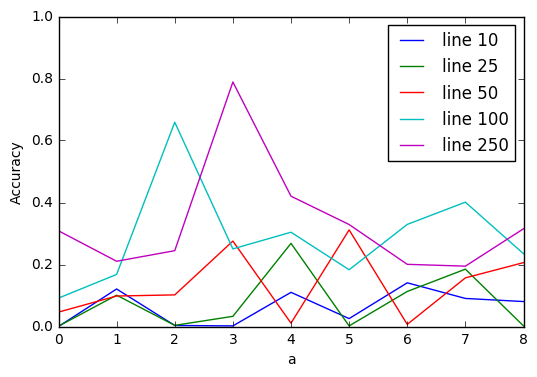

In [51]:
for n in [10, 25, 50, 100, 250]:
    data = [x for x in resultsSeparation[n].values()]
    plt.plot(data, label="line %d" % n)
plt.ylabel('Accuracy')
plt.xlabel('a')
plt.ylim((0,1))
plt.legend()

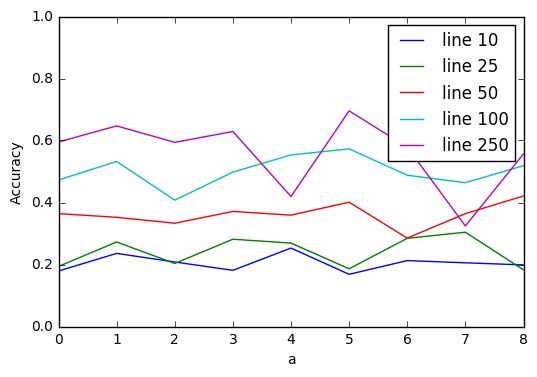

In [46]:
base = 1e-05
for n in [10, 25, 50, 100, 250]:
    data = [max(x.values()) for x in resultsAccuracy[n].values()]
    plt.plot(data, label="line %d" % n)
plt.ylabel('Accuracy')
plt.xlabel('a')
plt.ylim((0,1))
plt.legend()

In [ ]:
resultsAccuracy2 = {}
resultsTime2 = {}
resultsSeparation2 = {}
for n in [10, 25, 50, 100, 250, 500, 1000]:
    acc, t, sep = process(n, None, [10e-4, 10e-6])
    resultsAccuracy2[n] = acc
    resultsTime2[n] = t
    resultsSeparation2 = sep

In [ ]:
resultsAccuracy3 = {}
resultsTime3 = {}
resultsSeparation3 = {}
for n in [10, 25, 50, 100, 250, 500, 1000]:
    resultsAccuracy3[n] = {}
    resultsTime3[n] = {}
    resultsSeparation3[n] = {}
    for a in range(1,10):
        alpha = a / 10.0
        acc, t, sep = process(n, alpha, [10e-4, 10e-6])
        resultsAccuracy3[n] = acc
        resultsTime3[n] = t
        resultsSeparation[n] = sep

In [15]:
resultsAccuracy4 = {}
resultsTime4 = {}
resultsSeparation4 = {}
for n in [10, 25, 50, 100, 250, 500, 1000]:
    resultsAccuracy[n] = {}
    resultsTime[n] = {}
    for a in range(1,11):
        alpha = a / 10.0
        acc, t, sep = process(n, 1, [10e-4, 10e-6], density=alpha)
        resultsAccuracy4[n] = acc
        resultsTime4[n] = t
        resultsSeparation4 = sep

Accuracy: 18.000000%r size 10 for a 1.000000. 0
Accuracy: 18.000000%r size 10 for a 1.000000. 0
Accuracy: 22.000000%r size 10 for a 1.000000. 0
Accuracy: 25.000000%r size 10 for a 1.000000. 0
Accuracy: 17.000000%r size 10 for a 1.000000. 0
Accuracy: 16.000000%r size 10 for a 1.000000. 0
Accuracy: 18.000000%r size 10 for a 1.000000. 0
Accuracy: 23.000000%r size 10 for a 1.000000. 0
Accuracy: 36.000000%r size 10 for a 1.000000. 0
Accuracy: 18.000000%r size 10 for a 1.000000. 0
Accuracy: 18.000000%r size 25 for a 1.000000. 0
Accuracy: 18.000000%r size 25 for a 1.000000. 0
Accuracy: 18.000000%r size 25 for a 1.000000. 0
Accuracy: 30.000000%r size 25 for a 1.000000. 0
Accuracy: 36.000000%r size 25 for a 1.000000. 0
Accuracy: 39.000000%r size 25 for a 1.000000. 0
Accuracy: 28.000000%r size 25 for a 1.000000. 0
Accuracy: 31.000000%r size 25 for a 1.000000. 0
Accuracy: 29.000000%r size 25 for a 1.000000. 0
Accuracy: 32.000000%r size 25 for a 1.000000. 0
Accuracy: 39.000000%r size 50 for a 1.00

KeyboardInterrupt: 

In [30]:
resultSeparation

NameError: name 'resultSeparation' is not defined